# TP2 - Thiago Borges & Guilherme Leles

In [50]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import numpy as np
import time
import pygame
from pygame.locals import *
from OpenGL.GL import *
from OpenGL.GLU import *
from OpenGL.GLUT import *
from OpenGL import *
from objloader import *

## Função Espelhar alvo

Foi implementada para que pudéssemos ter 4 alvos, um em cada pose (rotacionando 90 graus entre cada alvo).
Assim dependendo de qual alvo for detectado pode-se ter uma ideia de qual a orientação do alvo identificado. Além disso, podemos analisar o alvo para qualquer que seja a homografia detectada desde que seja de um alvo correto

In [51]:
def espelha(i, erro1m, erro2m, erro3m, erro4m):
    if erro1m < 10500 or erro3m < 10500:
        guarda1 = i[0]
        guarda2 = i[2]
        i[0]= i[1]
        i[2]= i[3]
        i[1]=guarda1
        i[3]=guarda2
    elif erro2m < 10500 or erro4m < 10500:
        guarda1 = i[0]
        guarda2 = i[2]
        i[0]= i[3]
        i[2]= i[1]
        i[1]=guarda2
        i[3]=guarda1
    return i

In [52]:
def excluir_alvos_proximos(pontospnp2,pontospnp3):
    if len(pontospnp2) != 0: pontospnp3.append(pontospnp2[0])

    for i in pontospnp2:
        for j in i:
            for k in pontospnp3:
                for y in k:
                    if dist_euclidiana(j, y) < 5: flag = 0
        if flag == 1:
            pontospnp3.append(i)
        else:
            flag = 1
    return pontospnp3

## Função de template matching 

Nesta função é implementando metodo do erro quadrático médio,onde o score é o erro quadrático 
entre as duas imagens.

entradas: imagens a serem comparadas

saida: erro indicado na conta. Quanto menor o erro mais parecido

In [53]:
def compara1(imageA, imageB):
    # implementando metodo meanSquaredError
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    return err

## Distância euclidiana

Essa função calcula a distância euclidiana entre dois pontos 

Entradas: Pontos de distância a ser calculada


Saida: Distância 

In [54]:
def dist_euclidiana(v1, v2):
	dim, soma = len(v1), 0
	for i in range(dim):
		soma += math.pow(v1[i] - v2[i], 2)
	return math.sqrt(soma)


## Função de template matching 2

 Para o segundo método de template matching implementamos a conta de TM_CCORR normalizada, identificada por:

 

 


entrada: imagem e angulo a ser rotacionado

saida: imagem rotacionada

In [55]:
def  compara2(imageA, imageB):
    #implementando metodo CCORR

    numerador = np.sum((imageA.astype("float") * imageB.astype("float")))
    denominador1 = np.sum ( imageA.astype("float")**2)
    denominador2 = np.sum ( imageB.astype("float")**2)
    denominador = math.sqrt(denominador1*denominador2)
    err=numerador/denominador
    # err = numerador
    return err


## Função de homografias e template matching para identificar alvos dentre os "possíveis alvos" identificados anteriormente


Esta função segue a seguinte lógica:

-Temos todos os pontos identificados anteriormente, que identificam "Possiveis Alvos".

-Faz-se warpPerspective com esses pontos para as coordenadas dos alvos, que serão utilizados de comparação.

-Faz-se comparação com cada um dos 4 alvos (um em cada direção rotacionados em 90 graus entre si) utilizando uma das duas funções de similaridade (Template Matching) implementadas.

-Se houver algum erro menor ou igual ao threshold definido de 9500, a imagem é espelhada e novamente realizamos outra vez o Template Matching. 

-Caso seja identificado algum alvo após essas duas tentativas, plotamos as linhas coloridas na imagem original para identificá-lo.

-É importante lembrar que, qual dos 4 alvos for identificado, influenciará em qual linha será desenhada primeiro, pois o resultado final deve apresentar sempre a mesma linha na frente do alvo, independente de sua pose na cena.

In [56]:
def retorna_final(homografias,gray,final):
# HOMOGRAFIA------------------------------------------
    pontosPnP = []
    for i in homografias:
        
        aux1 = np.array([[i[0][1], i[0][0]], [i[3][1], i[3][0]], [i[2][1], i[2][0]], [i[1][1], i[1][0]]])
        aux2 = np.array([[0, 0], [0, tamXalvo], [tamYalvo, tamXalvo], [tamYalvo, 0]])
        h, status = cv2.findHomography(aux1, aux2)
        im_dst = cv2.warpPerspective(gray, h, (tamYalvo, tamXalvo))
        
        METODO=1
        if METODO == 1:
            erro1m = compara1(im_dst, alvo1m)
            erro2m = compara1(im_dst, alvo2m)
            erro3m = compara1(im_dst, alvo3m)
            erro4m = compara1(im_dst, alvo4m)
            if erro1m <= 9500 or erro2m <= 9500 or erro3m <= 9500 or erro4m <= 9500:
                i=espelha(i,erro1m,erro2m,erro3m,erro4m)
                aux1 = np.array([[i[0][1], i[0][0]], [i[3][1], i[3][0]], [i[2][1], i[2][0]], [i[1][1], i[1][0]]])
                aux2 = np.array([[0, 0], [0, tamXalvo], [tamYalvo, tamXalvo], [tamYalvo, 0]])
                h, status = cv2.findHomography(aux1, aux2)
                im_dst = cv2.warpPerspective(gray, h, (tamYalvo, tamXalvo))
            erro1 = compara1(im_dst, alvo1)
            erro2 = compara1(im_dst, alvo2)
            erro3 = compara1(im_dst, alvo3)
            erro4 = compara1(im_dst, alvo4)

                


            if erro1 <= 9500:
                final = cv2.line(final, (i[0][1], i[0][0]), (i[3][1], i[3][0]), (255, 0, 0), 2)
                final = cv2.line(final, (i[3][1], i[3][0]), (i[2][1], i[2][0]), (0, 255, 0), 2)
                final = cv2.line(final, (i[2][1], i[2][0]), (i[1][1], i[1][0]), (0, 0, 255), 2)
                final = cv2.line(final, (i[1][1], i[1][0]), (i[0][1], i[0][0]), (255, 255, 0), 2)
                pontosPnP.append([[i[2][1], i[2][0]],[i[1][1], i[1][0]],[i[0][1],i[0][0]],[i[3][1], i[3][0]]])
            if erro2 <= 10500:
                final = cv2.line(final, (i[0][1], i[0][0]), (i[3][1], i[3][0]), (255, 255, 0), 2)
                final = cv2.line(final, (i[3][1], i[3][0]), (i[2][1], i[2][0]), (255, 0, 0), 2)
                final = cv2.line(final, (i[2][1], i[2][0]), (i[1][1], i[1][0]), (0, 255, 0), 2)
                final = cv2.line(final, (i[1][1], i[1][0]), (i[0][1], i[0][0]), (0, 0, 255), 2)
                pontosPnP.append([[i[1][1], i[1][0]],[i[0][1],i[0][0]],[i[3][1], i[3][0]],[i[2][1], i[2][0]]])
            if erro3 <= 10500:
                final = cv2.line(final, (i[0][1], i[0][0]), (i[3][1], i[3][0]), (0, 0, 255), 2)
                final = cv2.line(final, (i[3][1], i[3][0]), (i[2][1], i[2][0]), (255, 255, 0), 2)
                final = cv2.line(final, (i[2][1], i[2][0]), (i[1][1], i[1][0]), (255, 0, 0), 2)
                final = cv2.line(final, (i[1][1], i[1][0]), (i[0][1], i[0][0]), (0, 255, 0), 2)
                pontosPnP.append([[i[0][1],i[0][0]],[i[3][1], i[3][0]],[i[2][1], i[2][0]],[i[1][1], i[1][0]]])
            if erro4 <= 10500:
                final = cv2.line(final, (i[0][1], i[0][0]), (i[3][1], i[3][0]), (0, 255, 0), 2)
                final = cv2.line(final, (i[3][1], i[3][0]), (i[2][1], i[2][0]), (0, 0, 255), 2)
                final = cv2.line(final, (i[2][1], i[2][0]), (i[1][1], i[1][0]), (255, 255, 0), 2)
                final = cv2.line(final, (i[1][1], i[1][0]), (i[0][1], i[0][0]), (255, 0, 0), 2)
                pontosPnP.append([[i[3][1], i[3][0]],[i[2][1], i[2][0]],[i[1][1], i[1][0]],[i[0][1],i[0][0]]])
        else:
            erro1 = compara2(im_dst, alvo1)
            erro2 = compara2(im_dst, alvo2)
            erro3 = compara2(im_dst, alvo3)
            erro4 = compara2(im_dst, alvo4)

            if erro1 >= 0.75:
                final = cv2.line(final, (i[0][1], i[0][0]), (i[3][1], i[3][0]), (255, 0, 0), 2)
                final = cv2.line(final, (i[3][1], i[3][0]), (i[2][1], i[2][0]), (0, 255, 0), 2)
                final = cv2.line(final, (i[2][1], i[2][0]), (i[1][1], i[1][0]), (0, 0, 255), 2)
                final = cv2.line(final, (i[1][1], i[1][0]), (i[0][1], i[0][0]), (255, 255, 0), 2)
            if erro2 >= 0.75:
                final = cv2.line(final, (i[0][1], i[0][0]), (i[3][1], i[3][0]), (255, 255, 0), 2)
                final = cv2.line(final, (i[3][1], i[3][0]), (i[2][1], i[2][0]), (255, 0, 0), 2)
                final = cv2.line(final, (i[2][1], i[2][0]), (i[1][1], i[1][0]), (0, 255, 0), 2)
                final = cv2.line(final, (i[1][1], i[1][0]), (i[0][1], i[0][0]), (0, 0, 255), 2)
            if erro3 >= 0.75:
                final = cv2.line(final, (i[0][1], i[0][0]), (i[3][1], i[3][0]), (0, 0, 255), 2)
                final = cv2.line(final, (i[3][1], i[3][0]), (i[2][1], i[2][0]), (255, 255, 0), 2)
                final = cv2.line(final, (i[2][1], i[2][0]), (i[1][1], i[1][0]), (255, 0, 0), 2)
                final = cv2.line(final, (i[1][1], i[1][0]), (i[0][1], i[0][0]), (0, 255, 0), 2)
            if erro4 >= 0.75:
                final = cv2.line(final, (i[0][1], i[0][0]), (i[3][1], i[3][0]), (0, 255, 0), 2)
                final = cv2.line(final, (i[3][1], i[3][0]), (i[2][1], i[2][0]), (0, 0, 255), 2)
                final = cv2.line(final, (i[2][1], i[2][0]), (i[1][1], i[1][0]), (255, 255, 0), 2)
                final = cv2.line(final, (i[1][1], i[1][0]), (i[0][1], i[0][0]), (255, 0, 0), 2)
    return final, pontosPnP



# Rotate image

In [57]:
Função que roda alvo para obtermos 4 alvos para o template matching


SyntaxError: invalid syntax (<ipython-input-57-b9cd2dd6334c>, line 1)

In [58]:
entrada: imagem e angulo a ser rotacionado


SyntaxError: invalid syntax (<ipython-input-58-83b36cb9af1b>, line 1)

In [59]:
saida: imagem rotacionada

SyntaxError: invalid syntax (<ipython-input-59-7ca7b98afda3>, line 1)

In [60]:
def rotateImage(image, angleInDegrees):
    h, w = image.shape[:2]
    img_c = (w / 2, h / 2)

    rot = cv2.getRotationMatrix2D(img_c, angleInDegrees, 1)

    rad = math.radians(angleInDegrees)
    sin = math.sin(rad)
    cos = math.cos(rad)
    b_w = int((h * abs(sin)) + (w * abs(cos)))
    b_h = int((h * abs(cos)) + (w * abs(sin)))

    rot[0, 2] += ((b_w / 2) - img_c[0])
    rot[1, 2] += ((b_h / 2) - img_c[1])

    outImg = cv2.warpAffine(image, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
    return outImg

## Função para encontrar os retângulos(alvos)

Nessa função utilizamos as funções para encontrar todos os contornos fechedaos na cena e depois filtramos todos os retângulos.

Entradas: Pontos para possível homografia, Matrix do poligono, frame original

In [61]:
Saida: Pontos para possível homografia, Matrix do poligono, frame original

SyntaxError: invalid syntax (<ipython-input-61-cd82e169635f>, line 1)

In [62]:
def find_rectangle(approx,original,homografias):
    pontos=[]
    for contour in imageContours:
        epsilon = 0.009 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, closed=True)

        x = approx.ravel()[0]
        y = approx.ravel()[1]
        if len(approx) == 4:
            pontos.append([approx[0][0],approx[1][0],approx[2][0],approx[3][0]])
    
    return approx,original, pontos


In [63]:
def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)


## FunctionPNP

Funcao que recebe parametros utilizados para calcular o pnp e gerar a matriz de transformação a ser utilizada
translação e rotação de cada objeto em relação de cada alvo


saidas: m -> lista com matrizes de transformação a serem injetadas na opengl


matrizRotacao -> lista com matrizes de rotação


matrizTranslaçao -> lista com matrizes de translação

In [64]:
def functionPnP(pontospnp, objectPoints, cameraMatrix, distCoeffs):
    matrizRotacao = []
    matrizTanslacao = []
    m=[]
    for i in pontospnp:
        imagePoints = np.asarray([i[0],i[1],i[2],i[3]])
        ret, rvec, tvec, = cv2.solvePnP(objectPoints.astype(float), imagePoints.astype(float), cameraMatrix, distCoeffs)

       
        tvec=tvec/math.sqrt((cameraMatrix[0][0]*cameraMatrix[0][0]+cameraMatrix[1][1]*cameraMatrix[1][1])*0.035)
        rotm=cv2.Rodrigues(rvec)[0]
        matrizRotacao.append(rotm)
        matrizTanslacao.append(tvec)
        
        matrizAuxiliar = np.array([[rotm[0][0], rotm[0][1], rotm[0][2], tvec[0]],
                                                [rotm[1][0], rotm[1][1], rotm[1][2], tvec[1]],
                                                [rotm[2][0], rotm[2][1], rotm[2][2], tvec[2]],
                                                [0.0, 0.0, 0.0, 1.0]])

       
        matrizAuxiliar = matrizAuxiliar*np.array(
            [[1.0, 1.0, 1.0, 1.0],
             [-1.0, -1.0, -1.0, -1.0],
             [-1.0, -1.0, -1.0, -1.0],
             [1.0, 1.0, 1.0, 1.0]]
        )
        m.append(matrizAuxiliar)

    return m, matrizRotacao, matrizTanslacao



##Init Opengl

Função que inicializa a openGL definindo os parametros iniciais e passando os parametros da camera


entradas: matriz da camera obtida por calibração e dimensões do frame


saida: objeto e id a ser utilizado para plotar o background na opengl

In [65]:
def initOpenGL(cameraMatrix, dimensions):

    (tamX, tamY) = dimensions

    glClearColor(0.0,0.0,0.0,0.0)
    glClearDepth(1.0)
    glDepthFunc(GL_LESS)
    
    glShadeModel(GL_SMOOTH)
   

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    Fx= cameraMatrix[0,0]
    Fy= cameraMatrix[1,1]
    FieldOfView= 2*np.arctan(0.5*tamY/Fy)*180/np.pi
    aspect= (tamX*Fy)/(tamY*Fx)
    gluPerspective(FieldOfView, aspect, 0.1, 300.0)
    
    glMatrixMode(GL_MODELVIEW)

    obj= OBJ("Pikachu.obj", swapyz=True)
    
    glEnable(GL_TEXTURE_2D)
    background_id= glGenTextures(1)
    return obj, background_id


In [66]:
#----------------parametros de calibração obtidos com o toolkit:---------------------------------------------------------
# Calibration results (with uncertainties):
#
# Focal Length:          fc = [ 568.45087   563.55473 ] ± [ 22.45520   20.58540 ]
# Principal point:       cc = [ 312.86352   207.41694 ] ± [ 8.63367   17.37837 ]
# Skew:             alpha_c = [ 0.00000 ] ± [ 0.00000  ]   => angle of pixel axes = 90.00000 ± 0.00000 degrees
# Distortion:            kc = [ 0.10977   -0.29957   -0.00915   -0.00096  0.00000 ] ± [ 0.02947   0.10084   0.00685   0.00569  0.00000 ]
# Pixel error:          err = [ 0.23016   0.28244 ]
#
# Note: The numerical errors are approximately three times the standard deviations (for reference).
#------------------------------------------------------------------------------------------------------------------------
# cameraMatrix= np.array([[568.45087,0,312.86352],[0,563.55473,207.41694],[0,0,1]])
# distCoeffs=np.array([ 0.10977 ,  -0.29957 ,  -0.00915  , -0.00096 , 0.00000 ])

cameraMatrix= np.array([[548.45087,0,312.86352],[0,536.62930,225.41694],[0,0,1]])
distCoeffs=np.array([ 0.06835  , -0.11194  , -0.00436  , -0.00248 , 0.00000 ])

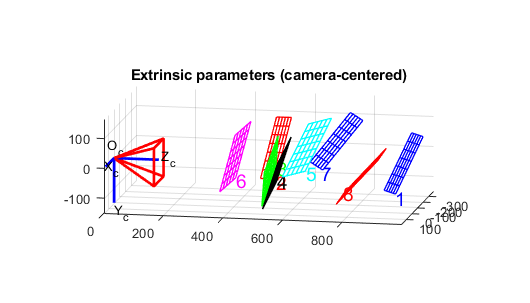

In [67]:
#---------------------------MAIN CODE-----------------------------------------------------------------------------------

img = cv2.imread('alvo.jpg', 0) #Lê alvo
crop_img = img[:, 3:-4]  #transforma alvo em figura quadrada

METODO=0
#cria 4 alvos para comparar no futuro
alvo1=np.copy(crop_img)
alvo2= rotateImage(alvo1,90)
alvo3= rotateImage(alvo2,90)
alvo4= rotateImage(alvo3,90)

alvo1m=cv2.flip(alvo1,0)
alvo2m= rotateImage(alvo1m,90)
alvo3m= rotateImage(alvo2m,90)
alvo4m= rotateImage(alvo3m,90)

#captura video
cap = cv2.VideoCapture('entrada.avi')

#captura dimensões do video
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))


rows = frame_height  # salva em variável rows numero de linhas
cols = frame_width   # salva em variável cols numero de colunas

tamXalvo = alvo1.shape[1]   #salva tamanho do alvo em X
tamYalvo = alvo1.shape[0]   #salva tamanho do alvo em Y
contaframes=0
# framesCalibrar=[]


In [68]:
para=0
contaRoda=0
glutInit()
glutInitWindowSize(cols, rows)
glutCreateWindow("TP2-Thiago_Borges & Guilherme Leles")
glutInitDisplayMode(GLUT_DOUBLE | GLUT_RGB)
glClearColor(0.0, 0.0, 0.0, 0.0)
obj, background_id= initOpenGL(cameraMatrix,(cols,rows))
contapnpsAtual=[]
guardapnps=[]
contaframes=0
intervaloFrame=8
s=0

In [69]:
def opengl_return(frame,M):

    #-------------INICIO-DO-OPENGL---------------------

    background = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    background = cv2.flip(background, 0)

    height, width, channels = background.shape
    background = np.fromstring(background.tostring(), background.dtype, height * width * channels)
    background.shape = (height, width, channels)


    try:
        glPopMatrix()
    except:
        print("erro")

    glEnable(GL_TEXTURE_2D)

    glBindTexture(GL_TEXTURE_2D, background_id)

    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGB, width, height, 0, GL_RGB, GL_UNSIGNED_BYTE, background)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_LINEAR)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_LINEAR)
    # glActiveTexture(GL_TEXTURE0)

    glGenerateMipmap(GL_TEXTURE_2D)

    glDepthMask(GL_TRUE)
    glEnable(GL_DEPTH_TEST)
    
    glMatrixMode(GL_PROJECTION)
    glPushMatrix()

    glLoadIdentity()
    gluOrtho2D(0, width, 0, height)



    glMatrixMode(GL_MODELVIEW)

    glBindTexture(GL_TEXTURE_2D, background_id)


    glPushMatrix()
    glBegin(GL_QUADS)
    glTexCoord2i(0,0)
    glVertex2i(0,0)
    glTexCoord2i(1,0)
    glVertex2i(width,0)
    glTexCoord2i(1,1)
    glVertex2i(width, height)
    glTexCoord2i(0,1)
    glVertex2i(0,height)
    glEnd()
    

    glPopMatrix()
    glMatrixMode(GL_PROJECTION)
    glPopMatrix()
    glMatrixMode(GL_MODELVIEW)
   
    glDisable(GL_TEXTURE_2D)

    glMatrixMode(GL_MODELVIEW)
    glPushMatrix()
    glLoadIdentity()

    kll = 0
    for i in M:
        
        glMatrixMode(GL_MODELVIEW)
        glPushMatrix()
        glLoadIdentity()
        glLoadMatrixf(np.transpose(i))
        glCallList(obj.gl_list)
        glPopMatrix()
        
    glutSwapBuffers()

    return 0

In [ ]:
while (1):
    contaframes+=1
    # reads frames from a camera
    ret, frame = cap.read()
    if not ret: break  #se chegar no final sai da rotina
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    original = np.copy(frame)
    final = np.copy(original)

    mask1= cv2.Canny(frame,200,300)
    imageContours, contours =  cv2.findContours(mask1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)



    k = cv2.waitKey(5) & 0xFF   #se pressionar esc sai da rotina

    if k == 27 or s==1:
        break


    homografias=[]
    approx=[]

    approx, original ,quinas= find_rectangle(approx,original,homografias)


#
    for i in quinas:
        for j in i:
            guarda=j[1]
            j[1]=j[0]
            j[0]=guarda

    final, pontospnp = retorna_final(quinas, gray, final)

    var=tamXalvo

    objectPoints = np.array(
        [[tamXalvo / 2, tamYalvo/ 2, 0], [-tamXalvo / 2, tamYalvo / 2, 0],[-tamXalvo / 2,  -tamYalvo/ 2, 0],[tamXalvo / 2, -tamYalvo / 2, 0]])

    matRotacao=[]
    tamYalvo=tamXalvo

    vecTranslacao=[]

    pontospnp2=[]

    pontospnp2 = excluir_alvos_proximos(pontospnp, pontospnp2)

    if contaframes<intervaloFrame: contapnpsAtual.append(len(pontospnp2))
    else :
        contapnpsAtual.append(len(pontospnp2))
        contapnpsAtual.pop(0)

    if len(pontospnp2)== max(contapnpsAtual):
        guardapnps=[]
        for i in pontospnp2:
            guardapnps.append(i)
    else:
        for i in guardapnps:
            if i in pontospnp2:
                a=0
            else:
                pontospnp2.append(i)

    pontospnp3 = []

    pontospnp3 = excluir_alvos_proximos(pontospnp2, pontospnp3)
   

    
    M,matRotacao,vecTranslacao = functionPnP(pontospnp3, objectPoints, cameraMatrix, distCoeffs)



    cv2.imshow('Contornos', final)


    opengl_return(frame,M)  
    


cap.release()




/home/guilhermeleles/anaconda3/envs/pip/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


erro
